In [32]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import nilearn
from nilearn.plotting import plot_stat_map, plot_glass_brain
import pickle
import json
from typing import Dict, List, Tuple
import warnings
from scipy import stats
from scipy.stats import sem
warnings.filterwarnings('ignore')


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 6,
    'xtick.labelsize': 6,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [33]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [34]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = os.path.join(scratch_dir, "output_RR")
SAVE_DIR = os.path.join(OUTPUT_DIR, "00_final_figures")
os.makedirs(SAVE_DIR, exist_ok=True)
PARCELLATION_DIR = os.path.join(scratch_dir, "data", "combined_parcellations")

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#E1BE6A',      # Yellow/colorblind friendly
    'affair_light': '#F2CB69', # Light yellow/colorblind friendly
    'paranoia': '#40B0A6',    # Green/colorblind friendly
    'paranoia_light': '#90ee90', # Light green/colorblind friendly
    'combined': '#6B15A7',    # Purple/colorblind friendly
    'combined_light': '#C448C5', # Light purple/colorblind friendly
    'balanced': '#3096DF',   # Blue/colorblind friendly
    'balanced_light': '#BFF5F9' # Light blue/colorblind friendly
}

In [35]:
SAVE_DIR_FIG3 = os.path.join(SAVE_DIR, "figure3")
os.makedirs(SAVE_DIR_FIG3, exist_ok=True)

In [36]:
def load_data(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = Path(OUTPUT_DIR) / f"04_{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics"
    
    # Load metrics
    metrics_path = base_path / f"{group}_metrics.pkl"
    try:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
    except Exception as e:
        print(f"Error loading metrics for {group}, n_state={n_state}: {e}")
        metrics = None
    
    # Load summary
    summary_path = base_path / f"{group}_summary.json"
    try:
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    except Exception as e:
        print(f"Error loading summary for {group}, n_state={n_state}: {e}")
        summary = None
    
    return {'metrics': metrics, 'summary': summary}

In [37]:
n_parcels = 400  # Use your actual parcellation number
atlas_file = Path(PARCELLATION_DIR)/f"Schaefer2018_400Parcels_Kong2022_17Networks_order.dscalar.nii"
atlas_img = nib.load(atlas_file)
atlas_data = atlas_img.get_fdata()

# Load the cortical labels
# Load the cortical labels
labels_file = Path(PARCELLATION_DIR)/f"Schaefer2018_400Parcels_Kong2022_17Networks_order_info.txt"

# Create a list to hold the parsed data
parsed_labels = []

# Read the file line by line
with open(labels_file, 'r') as f:
    lines = f.readlines()
    
# Process the file - each pair of lines contains the label and the index/color info
for i in range(0, len(lines), 2):
    if i+1 < len(lines):
        name = lines[i].strip()
        index = int(lines[i+1].split()[0])
        network = name.split('_')[2]  # Extract network name (third part)
        parsed_labels.append({"index": index, "name": name, "network": network})

# Convert to DataFrame
labels = pd.DataFrame(parsed_labels)

# Get network indices
unique_networks = np.unique(labels["network"])
network_indices = {network: np.array(labels[labels["network"] == network]["index"].tolist()) 
                   for network in unique_networks}

In [38]:
def create_state_brain_maps(state_properties, state_num, network_indices, atlas_data):
    """Create a brain map for a given state.
    Parameters:
        state_properties: Dict
            The state properties for the given state.
        state_num: int
            The original index of the state to create a brain map for.
        network_indices: Dict
            A dictionary mapping network names to their corresponding parcel indices.
        atlas_data: np.ndarray
            The atlas data with parcel indices.
    Returns:
        state_map: np.ndarray
            The brain map for the given state.
    """
    # Get the mean pattern for this state
    mean_pattern = state_properties[state_num]['mean_pattern']
    
    # Create an empty volume the same shape as the atlas
    state_map = np.zeros_like(atlas_data)
    
    # Map network values to parcels
    network_idx = 0
    for network, indices in network_indices.items():
        # Assign the corresponding value to each parcel in the network
        for parcel in indices:
            # Find voxels belonging to this parcel
            parcel_mask = atlas_data == parcel
            # Assign the pattern value to these voxels
            if network_idx < len(mean_pattern):  # Make sure we don't exceed pattern length
                state_map[parcel_mask] = mean_pattern[network_idx]
        
        # Move to next network
        network_idx += 1
        
    return state_map[0]

In [39]:
from neuromaps.datasets import fetch_fslr

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']

In [ ]:
but

  Summary Table:

  | Cluster | Model    | Original State | Sorted State | Occupancy | Interpretation                     |
  |---------|----------|----------------|--------------|-----------|------------------------------------|
  | 1       | 2-state  | 0              | 0            | 57.78%    | Most common state in 2-state model |
  | 2       | 7-state  | 4              | 4            | 12.56%    | 5th most common in 7-state model   |
  | 3       | 2-state  | 1              | 1            | 42.22%    | Less common state in 2-state model |
  | 4       | 6-state  | 3              | 2            | 15.39%    | 3rd most common in 6-state model   |
  | 5       | 20-state | 3              | 1            | 8.27%     | 2nd most common in 20-state model  |

# Cluster 1

model_idx = 2

sorted_state_idx = 0

original_state_idx = 0


In [41]:
combined_cluster1_2states_results = load_data(group="combined", n_state=2)
combined_cluster1_2states_metrics = combined_cluster1_2states_results['metrics']
combined_cluster1_2states_summary = combined_cluster1_2states_results['summary']
combined_cluster1_2states_properties = combined_cluster1_2states_metrics['state_properties']

In [42]:
cluster1_2states_brain_maps = create_state_brain_maps(combined_cluster1_2states_properties, 0, network_indices, atlas_data)

In [43]:
from surfplot import Plot

p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer(cluster1_2states_brain_maps, cmap='RdBu_r', color_range=(-0.3, 0.3))
fig = p.build()
# show figure, as you typically would with matplotlib
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster1_2states_brain_map_square.png", dpi=300, bbox_inches='tight')
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster1_2states_brain_map_square.svg", bbox_inches='tight')
fig.show()
plt.close(fig)

In [44]:
p = Plot(surf_lh=lh, surf_rh=rh, size=(800, 200), zoom=1.2, layout='row')
p.add_layer(cluster1_2states_brain_maps, cmap='RdBu_r', color_range=(-0.3, 0.3))
fig = p.build(figsize=(4, 2))
# show figure, as you typically would with matplotlib
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster1_2states_brain_map_row.png", dpi=300, bbox_inches='tight')
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster1_2states_brain_map_row.svg", bbox_inches='tight')
fig.show()
plt.close(fig)

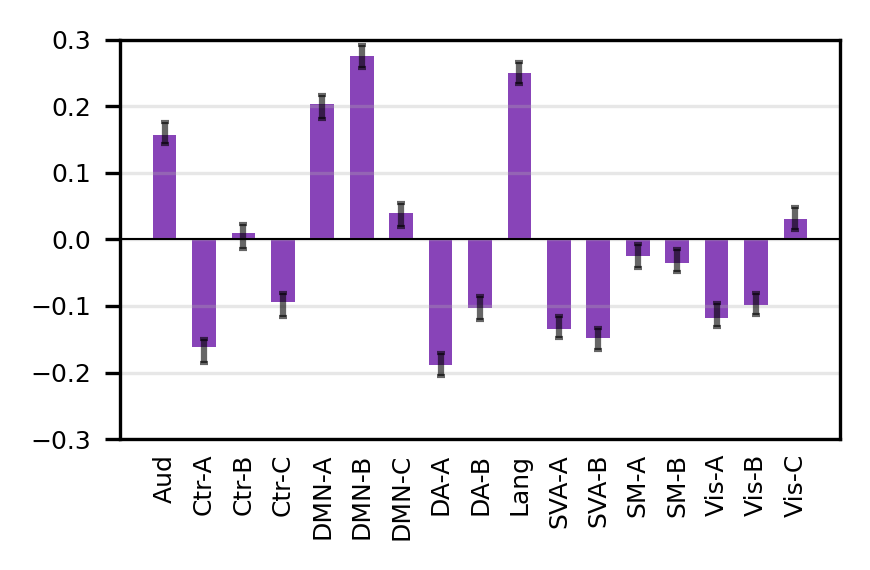

In [45]:
plot_state_pattern(combined_cluster1_2states_properties, state_num=0, cluster_idx=0, n_state=2, ylim=(-0.3, 0.3))

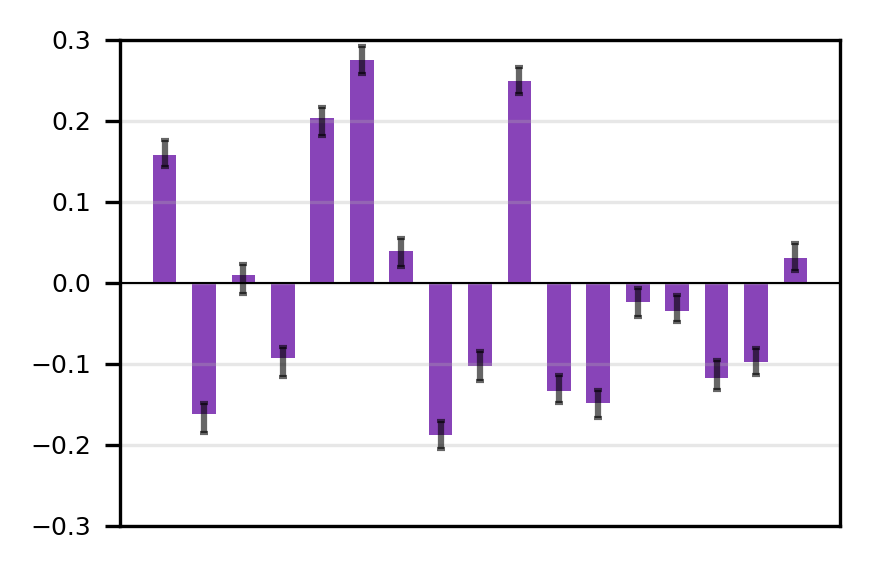

In [46]:
plot_state_pattern(combined_cluster1_2states_properties, state_num=0, cluster_idx=0, n_state=2, ylim=(-0.3, 0.3), label=False)

# Cluster 2

model_idx = 7

sorted_state_idx = 4

original_state_idx = 4


In [47]:
combined_cluster2_7states_results = load_data(group="combined", n_state=7)
combined_cluster2_7states_metrics = combined_cluster2_7states_results['metrics']
combined_cluster2_7states_summary = combined_cluster2_7states_results['summary']
combined_cluster2_7states_properties = combined_cluster2_7states_metrics['state_properties']

In [48]:
cluster2_7states_brain_maps = create_state_brain_maps(combined_cluster2_7states_properties, 4, network_indices, atlas_data)

In [49]:
p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer(cluster2_7states_brain_maps, cmap='RdBu_r', color_range=(-0.65, 0.65))
fig = p.build()
# show figure, as you typically would with matplotlib
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster2_7states_brain_map_square.png", dpi=300, bbox_inches='tight')
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster2_7states_brain_map_square.svg", bbox_inches='tight')
fig.show()
plt.close(fig)

In [50]:
p = Plot(surf_lh=lh, surf_rh=rh, size=(800, 200), zoom=1.2, layout='row')
p.add_layer(cluster2_7states_brain_maps, cmap='RdBu_r', color_range=(-0.65, 0.65))
fig = p.build(figsize=(4, 2))
# show figure, as you typically would with matplotlib
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster2_7states_brain_map_row.png", dpi=300, bbox_inches='tight')
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster2_7states_brain_map_row.svg", bbox_inches='tight')
fig.show()
plt.close(fig)

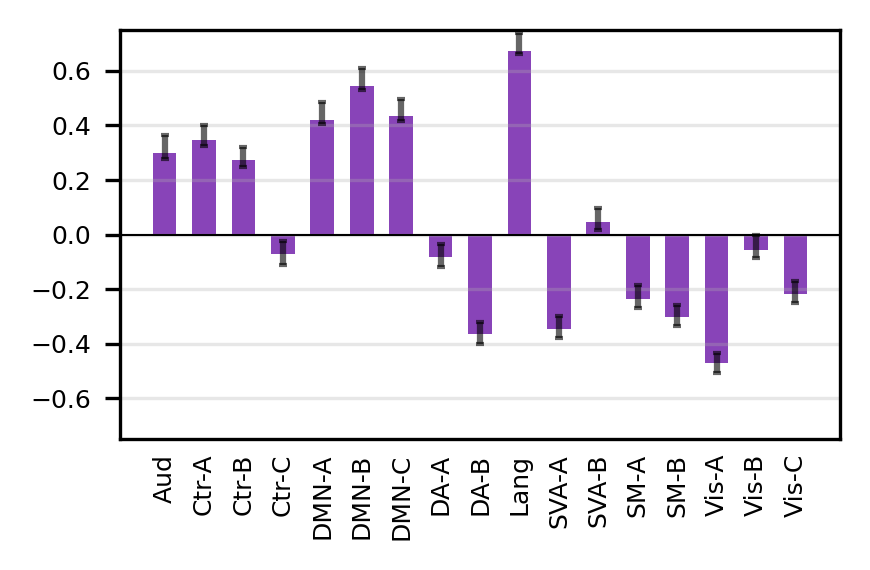

In [51]:
plot_state_pattern(combined_cluster2_7states_properties, state_num=4, cluster_idx=2, n_state=7, ylim=(-0.75, 0.75))

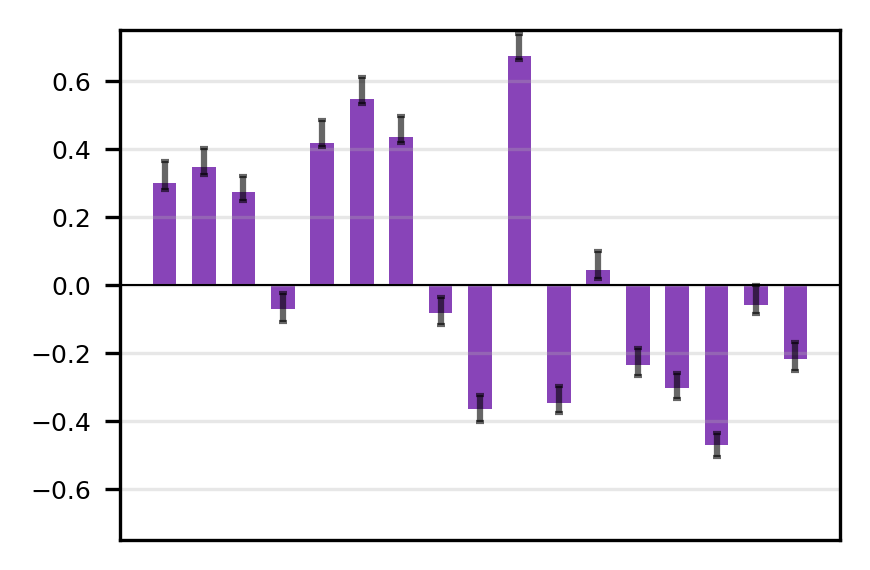

In [52]:
plot_state_pattern(combined_cluster2_7states_properties, state_num=4, cluster_idx=2, n_state=7, ylim=(-0.75, 0.75), label=False)

# Cluster 3

model_idx = 2

sorted_state_idx = 1

original_state_idx = 1


In [53]:
combined_cluster3_2states_results = load_data(group="combined", n_state=2)
combined_cluster3_2states_metrics = combined_cluster3_2states_results['metrics']
combined_cluster3_2states_summary = combined_cluster3_2states_results['summary']
combined_cluster3_2states_properties = combined_cluster3_2states_metrics['state_properties']

cluster3_2states_brain_maps = create_state_brain_maps(combined_cluster3_2states_properties, 1, network_indices, atlas_data)

In [54]:
p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer(cluster3_2states_brain_maps, cmap='RdBu_r', color_range=(-0.35, 0.35))
fig = p.build()
# show figure, as you typically would with matplotlib
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster3_2states_brain_map_square.png", dpi=300, bbox_inches='tight')
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster3_2states_brain_map_square.svg", bbox_inches='tight')
fig.show()
plt.close(fig)

In [55]:
p = Plot(surf_lh=lh, surf_rh=rh, size=(800, 200), zoom=1.2, layout='row')
p.add_layer(cluster3_2states_brain_maps, cmap='RdBu_r', color_range=(-0.35, 0.35))
fig = p.build()
# show figure, as you typically would with matplotlib
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster3_2states_brain_map_row.png", dpi=300, bbox_inches='tight')
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster3_2states_brain_map_row.svg", bbox_inches='tight')
fig.show()
plt.close(fig)

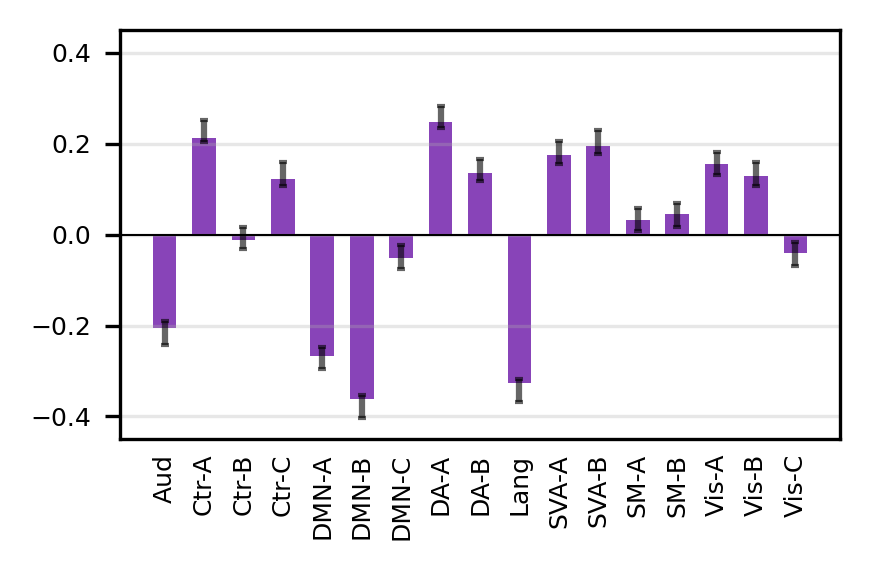

In [56]:
plot_state_pattern(combined_cluster3_2states_properties, state_num=1, cluster_idx=3, n_state=2, ylim=(-0.45, 0.45))

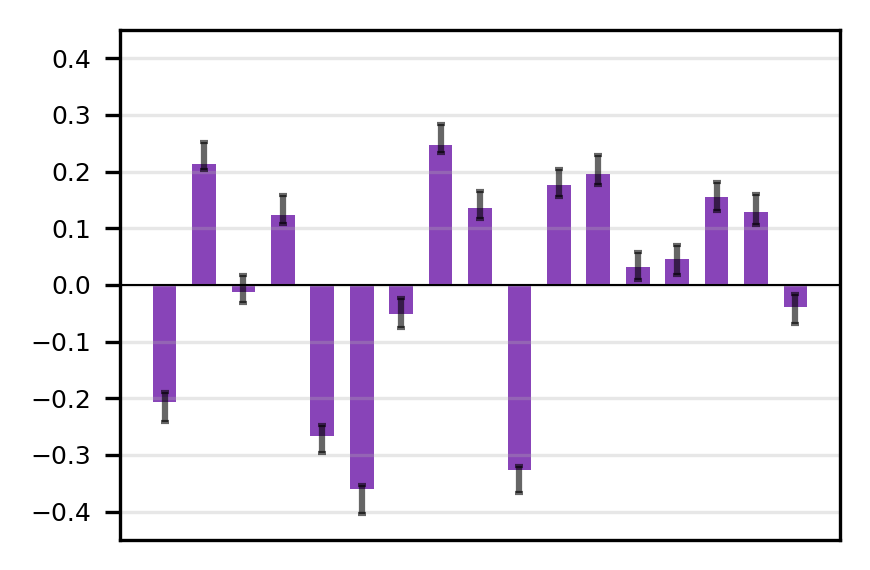

In [57]:
plot_state_pattern(combined_cluster3_2states_properties, state_num=1, cluster_idx=3, n_state=2, ylim=(-0.45, 0.45), label=False)

# Cluster 4

model_idx = 6

sorted_state_idx = 2

original_state_idx = 3


In [58]:
combined_cluster4_6states_results = load_data(group="combined", n_state=6)
combined_cluster4_6states_metrics = combined_cluster4_6states_results['metrics']
combined_cluster4_6states_summary = combined_cluster4_6states_results['summary']
combined_cluster4_6states_properties = combined_cluster4_6states_metrics['state_properties']

cluster4_6states_brain_maps = create_state_brain_maps(combined_cluster4_6states_properties, 3, network_indices, atlas_data)

In [59]:
p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer(cluster4_6states_brain_maps, cmap='RdBu_r', color_range=(-0.85, 0.85))
fig = p.build()
# show figure, as you typically would with matplotlib
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster4_6states_brain_map_square.png", dpi=300, bbox_inches='tight')
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster4_6states_brain_map_square.svg", bbox_inches='tight')
fig.show()
plt.close(fig)

In [60]:
p = Plot(surf_lh=lh, surf_rh=rh, size=(800, 200), zoom=1.2, layout='row')
p.add_layer(cluster4_6states_brain_maps, cmap='RdBu_r', color_range=(-0.85, 0.85))
fig = p.build()
# show figure, as you typically would with matplotlib
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster4_6states_brain_map_row.png", dpi=300, bbox_inches='tight')
plt.savefig(Path(SAVE_DIR_FIG3)/f"combined_cluster4_6states_brain_map_row.svg", bbox_inches='tight')
fig.show()
plt.close(fig)

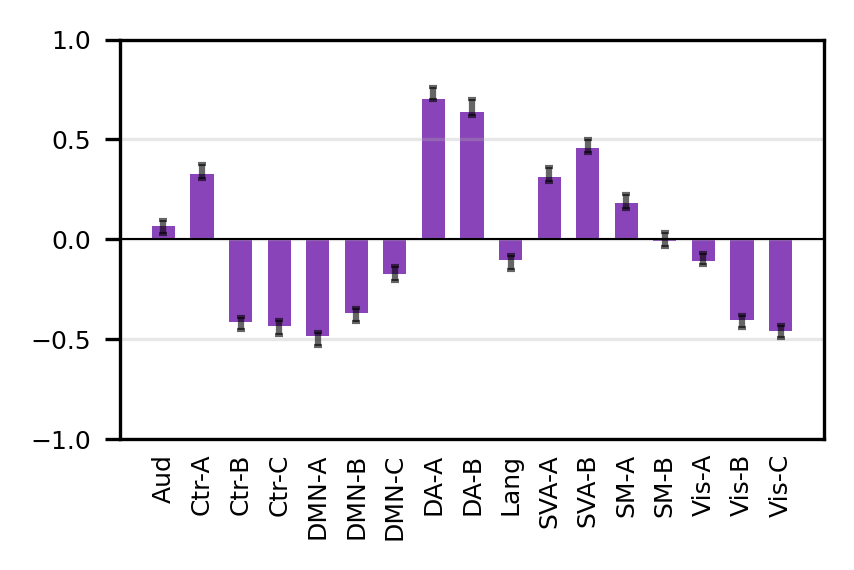

In [61]:
plot_state_pattern(combined_cluster4_6states_properties, state_num=3, cluster_idx=4, n_state=6, ylim=(-1, 1))

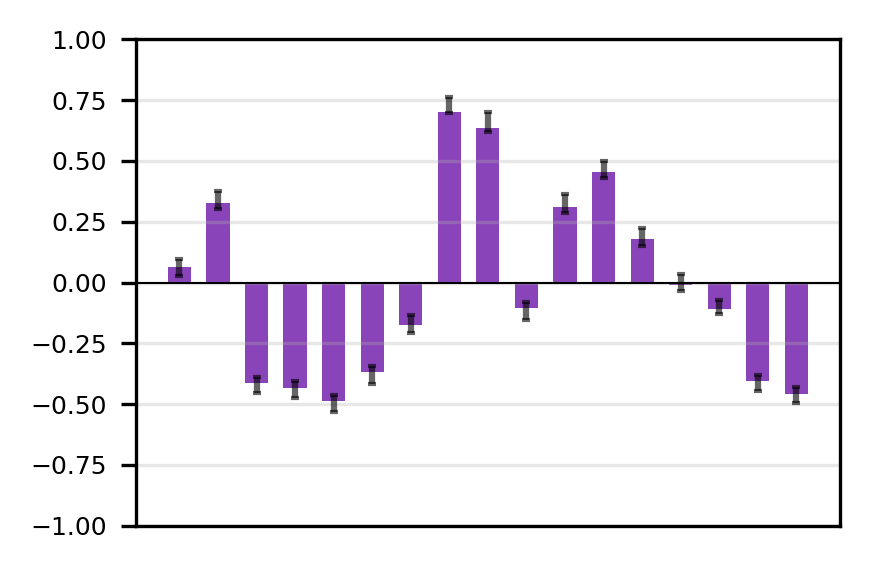

In [62]:
plot_state_pattern(combined_cluster4_6states_properties, state_num=3, cluster_idx=4, n_state=6, ylim=(-1, 1), label=False)